In [1]:
from importlib import reload
import bayes
reload(bayes)
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing  import scale
from sklearn.model_selection import KFold, ShuffleSplit
from utils import *
np.set_printoptions(precision=2)

In [2]:
def bmi(h, w):
    h = h*0.0254
    w = w * 0.453592
    return w / (h**2)

In [3]:
data = pd.read_csv("diabes.csv")
cols = ["chol", "glyhb", "stab.glu", "hdl", "age", "gender", "obe", "ow" , "bps", "bpd", "whr", "ppt", "> 55" ] # "bmi"

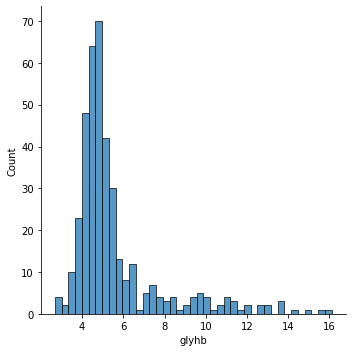

In [4]:
sns.displot(data, x = "glyhb")

In [5]:
data["whr"] = data["waist"] / data["hip"]
data["bmi"] = bmi(data["height"], data["weight"])
data["ppt"] = data["time.ppn"] < 120
data["obe"] = data["bmi"] > 30
data["ow"] = (data["bmi"] < 30) & (data["bmi"] > 25)
data["> 55"] = data["age"] > 55
data["bps"] = data["bp.1s"] #(data["bp.1s"] + data["bp.2s"])/2
data["bpd"] = data["bp.1d"] #(data["bp.1d"] + data["bp.2d"])/2
df = data[cols]; cols.remove("glyhb")
df = df[~pd.isna(df).any(axis = 1)]
df["gender"] = df["gender"] == "female"
#df["one"] = 1
y_ = df.pop("glyhb").to_numpy().astype(float)
X = df.to_numpy().astype(float)
y = scale(y_, with_std=False)
X = scale(X, with_mean=False)



In [279]:
model = bayes.Wayfay(nIter=1000, ld0=1, eps=5/10000)
model.fit(y, X)

Iter:  200
Iter:  400
Iter:  600
Iter:  800
Done


In [280]:
beta = model.variables["B"].storage.mean(axis = 0) 
gams = model.gammas.storage.mean(axis=0) 

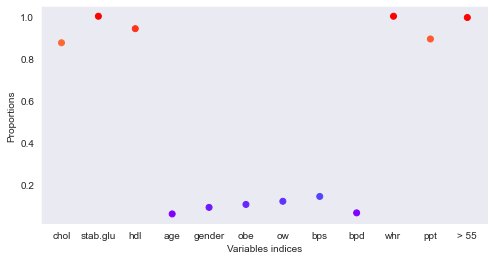

In [281]:
sns.set_style("dark")
plt.figure(figsize=(8, 4))
ax = plt.gca()
ax.scatter(y = gams, x = cols, c = gams,  cmap="rainbow") # cmap="cool"
ax.set_ylabel('Proportions')
ax.set_xlabel('Variables indices')
plt.show() 

<AxesSubplot:>

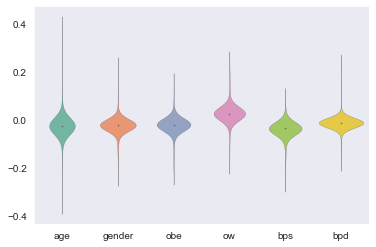

In [293]:
BM = pd.DataFrame(model.variables["B"].storage[:, gams > 0.5], columns=np.array(cols)[gams > 0.5])
ZM = pd.DataFrame(model.variables["B"].storage[:, gams < 0.5], columns=np.array(cols)[gams < 0.5])
#sns.violinplot(data=BM,palette="Set1", bw=1,  linewidth=1/4) 
sns.violinplot(data=ZM, palette="Set2", bw=1,  linewidth=1/4)

In [283]:
model.variables["sig"].storage.mean() , np.median(model.variables["sig"].storage), model.variables["sig"].storage[0]

(2.11577489133577, 2.1086758341113834, 2.086877609806347)

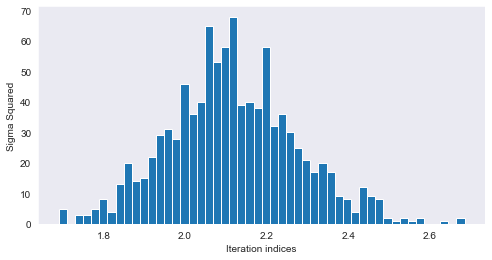

In [298]:
sns.set_style("dark")
plt.figure(figsize=(8, 4))
ax = plt.gca()
#ax.scatter(y = model.variables["sig"].storage, x = np.arange(1000),   cmap="rainbow") # cmap="cool"
ax.hist(model.variables["sig"].storage, bins=50)
ax.set_ylabel('Sigma Squared')
ax.set_xlabel('Iteration indices')
plt.show() 

In [284]:
gams = model.gammas.storage.mean(axis=0) 
#df.columns, gams, gams >  0.5
pd.DataFrame(gams.reshape(1, -1), columns=df.columns)

,chol,stab.glu,hdl,age,gender,obe,ow,bps,bpd,whr,ppt,> 55
0,0.874,1.0,0.941,0.061,0.092,0.106,0.121,0.144,0.066,1.0,0.892,0.994


In [247]:
np.random.seed(0)
shuffle_split = ShuffleSplit(n_splits=10)
scores = []; ciw = []; cov = []; alpha = 0.05/2
for i, (train_indexes, test_indexes) in enumerate(shuffle_split.split(X)):
    print("Fold: ", i)
    model = bayes.Wayfay(nIter=100, ld0=1, eps=5/10000) # 5/10000, 10/10000
    model.fit(y[train_indexes], X[train_indexes]) 
    BM = model.variables["B"].storage
    B = BM.mean(axis=0)
    X_ = X[test_indexes] ; y_ = y[test_indexes]
    pred = dot(X_, B)
    l, h = np.quantile(dot(X_, BM.T), q = [alpha, 1-alpha], axis =1)
    precision = ((l < pred) & (pred < h)).mean()
    diff = y_ - pred
    #diff = y[test_indexes] - np.exp(dot(X[test_indexes], B))
    mse = norm(diff)
    scores.append(mse)
    ciw.append(np.mean(h - l))
    cov.append(precision)
    print(mse, precision)

Fold:  0
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
1.7157183735050887 1.0
Fold:  1
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
1.2610586223060316 1.0
Fold:  2
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
0.8781424316024771 1.0
Fold:  3
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
1.282417535937153 1.0
Fold:  4
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
3.8302654126893585 1.0
Fold:  5
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
1.4115711624220297 1.0
Fold:  6
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
1.8172608857941275 1.0
Fold:  7
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
1.88201797272754 1.0
Fold:  8
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
1.6701486119230045 1.0
Fold:  9
Iter:  20
Iter:  40
Iter:  60
Iter:  80
Done
1.2555184572643916 1.0


In [285]:
np.mean(scores), np.mean(cov), np.mean(ciw)

(1.7004119466171201, 1.0, 1.9549625983743133)

In [307]:
fr = pd.DataFrame({"MSE":scores, "COV":cov, "CIW":ciw}, index=["Fold " + str(d+1) for d in np.arange(10)])

In [310]:
to_latex(fr.reset_index())

Fold 1 & 1.7157183735050887 & 1.0 & 2.1115433214007417 \\ 
Fold 2 & 1.2610586223060316 & 1.0 & 1.9684108175884563 \\ 
Fold 3 & 0.8781424316024771 & 1.0 & 2.0081607739168454 \\ 
Fold 4 & 1.282417535937153 & 1.0 & 2.012740163743705 \\ 
Fold 5 & 3.8302654126893585 & 1.0 & 2.1422807132558734 \\ 
Fold 6 & 1.4115711624220297 & 1.0 & 2.000029342786405 \\ 
Fold 7 & 1.8172608857941275 & 1.0 & 1.8812863928585193 \\ 
Fold 8 & 1.88201797272754 & 1.0 & 1.8047142038627897 \\ 
Fold 9 & 1.6701486119230045 & 1.0 & 1.8053154251051196 \\ 
Fold 10 & 1.2555184572643916 & 1.0 & 1.8151448292246766


In [11]:
np.mean([1.25, 1.24, 1.55, 1.21, 1.45, 1.47, 3.44, 1.23])

1.605

In [304]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

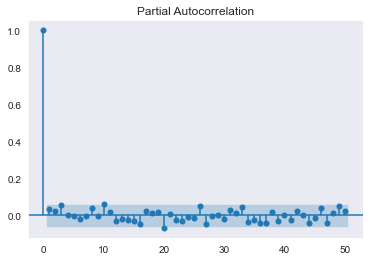

In [306]:
plot_pacf(model.variables["sig"].storage, lags = 50)
plt.show()

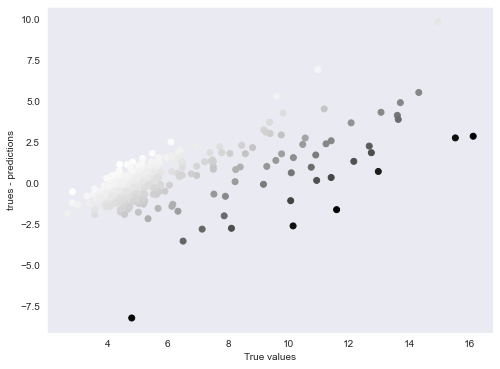

In [290]:
preds = dot(X, B)
errs = y - preds
#sns.set_style("dark")
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(y = errs, x = y_, c = preds,  cmap="Greys") # cmap="cool"
ax.set_ylabel('trues - predictions')
ax.set_xlabel('True values')
plt.show() 

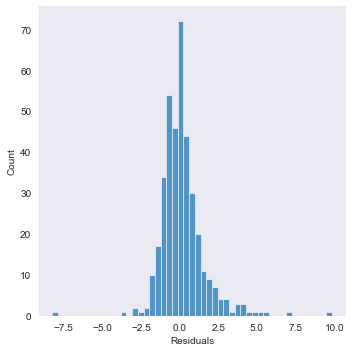

In [286]:
df["Residuals"] = errs
sns.displot(df, x = "Residuals")

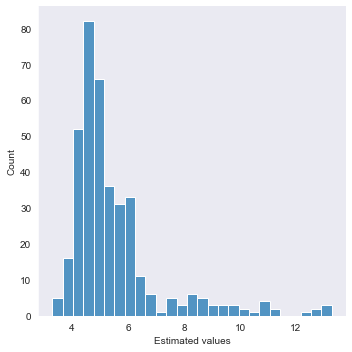

In [287]:
df["Estimated values"] = preds + y_.mean()
sns.displot(df, x = "Estimated values")

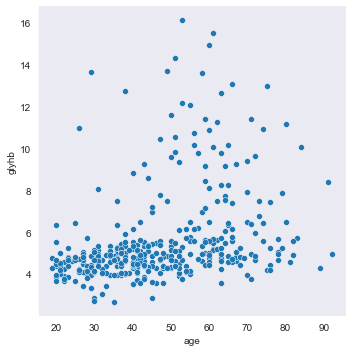

In [265]:
#sns.pairplot(data[["chol", "glyhb", "stab.glu","ppt"]], hue="ppt")
# 'chol', 'stab.glu', 'hdl', 'ratio', 'glyhb', 'location', 'age'
sns.relplot(x="age", y="glyhb", data = data)

In [6]:
from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split

In [17]:
#from scipy.stats import norm

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

[iter 0] loss=2.2345 val_loss=0.0000 scale=1.0000 norm=1.7275
[iter 100] loss=1.4028 val_loss=0.0000 scale=2.0000 norm=1.8604
[iter 200] loss=1.1014 val_loss=0.0000 scale=2.0000 norm=1.6265
[iter 300] loss=0.9505 val_loss=0.0000 scale=1.0000 norm=0.7762
[iter 400] loss=0.8572 val_loss=0.0000 scale=1.0000 norm=0.7515


In [13]:
x = Y_dists.params["scale"]

In [16]:
(x*4).mean()

2.3479895242303375

In [7]:
np.random.seed(0)
shuffle_split = ShuffleSplit(n_splits=10)
scores = []; ciw = []; cov = []; alpha = 0.05/2
for i, (train_indexes, test_indexes) in enumerate(shuffle_split.split(X)):
    print("Fold: ", i)
    model = NGBRegressor()
    model.fit(X[train_indexes], y[train_indexes]) 
    X_ = X[test_indexes] ; y_ = y[test_indexes]
    dists = model.pred_dist(X_).params
    pred = dists["loc"]
    sd = dists["scale"]
    l, h = pred - 1.96*sd, pred + 1.96*sd
    precision = ((l < pred) & (pred < h)).mean()
    diff = y_ - pred
    #diff = y[test_indexes] - np.exp(dot(X[test_indexes], B))
    mse = norm(diff)
    scores.append(mse)
    ciw.append(np.mean(h - l))
    cov.append(precision)
    print(mse, precision)

Fold:  0
[iter 0] loss=2.2469 val_loss=0.0000 scale=1.0000 norm=1.7486
[iter 100] loss=1.3903 val_loss=0.0000 scale=2.0000 norm=1.8452
[iter 200] loss=1.0717 val_loss=0.0000 scale=2.0000 norm=1.6128
[iter 300] loss=0.9349 val_loss=0.0000 scale=1.0000 norm=0.7671
[iter 400] loss=0.8489 val_loss=0.0000 scale=1.0000 norm=0.7404
1.8609847353450073 1.0
Fold:  1
[iter 0] loss=2.2439 val_loss=0.0000 scale=1.0000 norm=1.7206
[iter 100] loss=1.3964 val_loss=0.0000 scale=2.0000 norm=1.8701
[iter 200] loss=1.0970 val_loss=0.0000 scale=1.0000 norm=0.8231
[iter 300] loss=0.9680 val_loss=0.0000 scale=2.0000 norm=1.5644
[iter 400] loss=0.8831 val_loss=0.0000 scale=1.0000 norm=0.7544
2.1331079154542496 1.0
Fold:  2
[iter 0] loss=2.1881 val_loss=0.0000 scale=1.0000 norm=1.6499
[iter 100] loss=1.3395 val_loss=0.0000 scale=2.0000 norm=1.7844
[iter 200] loss=1.0325 val_loss=0.0000 scale=1.0000 norm=0.7865
[iter 300] loss=0.9054 val_loss=0.0000 scale=2.0000 norm=1.5110
[iter 400] loss=0.8333 val_loss=0.000

In [26]:
c = norm.cdf(0.95/2, Y_dists.params["loc"], Y_dists.params["scale"]) - norm.cdf(0.05/2, Y_dists.params["loc"], Y_dists.params["scale"])

In [8]:
np.mean(scores), np.mean(cov), np.mean(ciw)

(2.4415631752242484, 1.0, 2.5123156066942007)

In [37]:
scores

In [39]:
norm(diff)